* CPSC 599 W2024
* Final Project: Job Skills Extraction from Job Postings
* Duong Tran
* 30113765
* Group 26

In [74]:
%pip install beautifulsoup4
%pip install requests
import os
import re
import time

import h5py
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize
from nltk import ngrams
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

# Transformers and related libraries
import transformers
from transformers import pipeline, AutoTokenizer, AutoModel

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Extracting Job Descriptions from URLs
I will use BeautifulSoup to to parse through the raw HTML file to find text under 3 div properpy 'responsibilities', 'experienceRequirements' and 'skills' as the data for Job Descriptions.

In [200]:
import requests
def fetch_job_postings(url):
    """
    Fetch text from url
    """
    headers_to_extract = ['responsibilities', 'experienceRequirements', 'skills']
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        job_desc_div = soup.find('div', class_='job-posting-detail-requirements')
        extracted_text = []
        for header_property in headers_to_extract:
            header_div = job_desc_div.find('div', property=header_property)
            if header_div:
                # Remove headers from the div
                header_div = remove_headers(header_div)
                # Extract text from the div
                text = header_div.get_text(separator='\n')
                extracted_text.append(text)
        if extracted_text:
            # Concatenate all extracted sections into a single string
            job_description = '\n'.join(extracted_text)
            # Parse raw HTML into sentences
            sentences = get_sentences(job_description)
            # Remove empty lines
            sentences = [sentence for sentence in sentences if sentence.strip()]
            return sentences
        else:
            print("Job description sections not found in the page.")
            return []
    else:
        print(f"Failed to fetch job postings from {url}")
        return []

def get_sentences(job_html):
    """
    Given a raw html job description, parse it into sentences
    by using nltk's sentence tokenization + new line splitting
    """
    soup = BeautifulSoup(job_html, 'html.parser')
    # Found some ads using unicode bullet points
    for p in soup.find_all('p'):
        p.string = p.get_text().replace("•", "")
    text = soup.get_text()
    st = sent_tokenize(text)
    sentences = []
    for sent in st:
        sentences.extend([x.strip() for x in sent.split('\n') if x.strip()])
    return sentences

def remove_headers(soup):
    """
    Remove unwanted header name in the dataset
    """
    # Define a list of headers to remove
    headers_to_remove = ['h3', 'h4']
    # Find and remove headers
    for header in headers_to_remove:
        elements = soup.find_all(header)
        for element in elements:
            element.decompose()
    return soup

In [217]:
# Read URLs from the text file
url_file_path = 'sample_data/jobbank.txt'
with open(url_file_path, 'r') as file:
    urls = file.readlines()

# Initialize an empty DataFrame to store job postings
df = pd.DataFrame(columns=['Job Description'])

# Iterate over each URL and fetch job postings
for url in urls:
    url = url.strip()  # Remove leading/trailing whitespaces
    job_postings = fetch_job_postings(url)
    # Add fetched job postings to DataFrame
    job_desc = pd.DataFrame({'Job Description': job_postings})
    df = pd.concat([df, job_desc], ignore_index=True)

print(df)

# Print the length of the DataFrame after removing duplicates
print("Total Job Skills fetched:", len(df))


                                       Job Description
0      Write, modify, integrate and test software code
1    Maintain existing computer programs by making ...
2    Communicate technical problems, processes and ...
3    Prepare reports, manuals and other documentati...
4    Assist in the collection and documentation of ...
..                                                 ...
421                                                  C
422                                                 C#
423                               Software development
424             Associate Computing Professional (ACP)
425                        Microsoft SQL Certification

[426 rows x 1 columns]
Total Job Skills fetched: 426


In [216]:
print(df.iloc[28])

Job Description    Team player
Name: 28, dtype: object


## Load the job ads dataset and ESCO skills ontology
I removed duplicates from the job ads, the dataset is still very big, I won't be using all the entries.
<br>For the ESCO skills ontology, I will only be using the preferred labels and consider all entries as skills, even though ESCO divides them into subcategories.

In [219]:
ESCO_SKILLS_FP = 'sample_data/ESCO_skills_en.csv'
esco_df = pd.read_csv(ESCO_SKILLS_FP)
# Remove "(text)" occurences
esco_df['label_cleaned'] = esco_df['preferredLabel'].apply(lambda x: re.sub(r'\([^)]*\)', '', x).strip())
# Count words in skills after cleaning
esco_df['word_cnt'] = esco_df['label_cleaned'].apply(lambda x: len(str(x).split()))
esco_df = pd.DataFrame(esco_df, columns=['label_cleaned', 'altLabels', 'word_cnt'])
print("N esco cleaned: ", len(esco_df))

N esco cleaned:  13485


**Skills lengths**<br>
I checked the word count frequency in ESCO skills, most of them consist of 3 words and just by looking you could say almost no skills consist of more than 9 words. I planned to use this for determining the maximal ngram length, but in the end opted for whole sentence representation

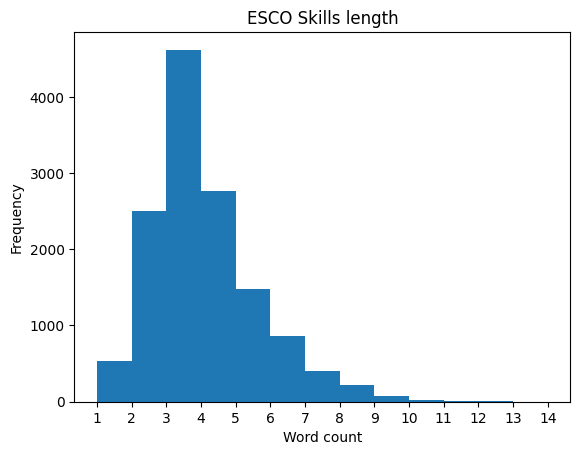

In [220]:
max_value = max(esco_df.word_cnt)
bins = range(1, max_value + 2)

plt.hist(esco_df.word_cnt, bins=bins)
plt.xticks(range(1, max_value + 2))

plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.title('ESCO Skills length')
plt.savefig('esco_word_count.png')
plt.show()

In [221]:
class EscoDataset(Dataset):
    def __init__(self, df, skill_col, backbone):
        texts = df
        self.tokenizer = AutoTokenizer.from_pretrained(backbone)
        self.texts = texts[skill_col].values.tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        res = self.tokenizer(
            self.texts[idx],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=20
        )
        return {k:v[0] for k,v in res.items()}

class ClsPool(nn.Module):
    def forward(self, x):
        # batch * num_tokens * num_embedding
        return x[:, 0, :]


class BertModel(nn.Module):
    def __init__(self, backbone):
        super().__init__()

        self.backbone_name = backbone
        self.backbone = AutoModel.from_pretrained(backbone)
        self.pool = ClsPool()

    def forward(self, x):
        x = self.backbone(**x)["last_hidden_state"]
        x = self.pool(x)

        return x

## JobBERT
JobBERT is a BERT model pre-trained on job propositions, it came from a paper where they concluded that a domain-specific pretrained model outperformed the non-adapted versions and published their model on [Huggingface](https://huggingface.co/jjzha/jobbert-base-cased). I will use it to create embeddings of ESCO skills, then embed the job postings and find relevant ESCO skills using vector similarity (around 15 mins runtime)

In [222]:
backbone = 'jjzha/jobbert-base-cased'
emb_label = 'jobbert'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and Dataloader
ds = EscoDataset(esco_df, 'label_cleaned', backbone)
dl = DataLoader(ds, shuffle=False, batch_size=32)

# Build custom model
model = BertModel(backbone)
model.eval()
model.to(device)

# Get embeddings for each skill
embs = []
with torch.no_grad():
    for i, x in enumerate(dl):
        x = {k:v.to(device) for k, v in x.items()}
        out = model(x)
        embs.extend(out.detach().cpu())
# Add them to the DataFrame
esco_df[emb_label] = embs

Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Compute Similarity between ESCO Skills and Extracted Job Skills

In [224]:
def compute_similarity(vec, emb_type):
    """
    Compute vector similarity for a given vec and all the ESCO skills embeddings.
    If more embeddings were created, the type is specified by the input parameter.
    Return the ESCO skill id with max similarity
    """
    esco_embs = esco_df[emb_type]
    sims = []
    # Compute cosine similarities
    for i, esco_vec in enumerate(esco_embs):
        sims.append((i, cosine_similarity(vec, esco_vec.reshape(1, -1))))
    # Return max similarity and esco skill index
    idx, sim = max(sims, key=lambda x: x[1])
    return idx, sim.item()

def compute_similarity_opt(emb_vec, emb_type):
    """
    Compute vector similarity for a given vec and all the ESCO skills embeddings
    by constructing a matrix from ESCO embeddings to process it faster.
    Return the ESCO skill id with max similarity
    """
    esco_embs = [x for x in esco_df[emb_type]]
    esco_vectors = torch.stack(esco_embs)
    # Normalize the stacked embeddings and the input vector
    norm_esco_vectors = torch.nn.functional.normalize(esco_vectors, p=2, dim=1)
    norm_emb_vec = torch.nn.functional.normalize(emb_vec.T, p=2, dim=0)
    # Compute cosine similarities
    cos_similarities = torch.matmul(norm_esco_vectors, norm_emb_vec)
    # Return max similarity and esco skill index
    sim, idx = torch.max(cos_similarities, dim=0)
    return idx.item(), sim.item()

def compute_similarity_mat(emb_mat, emb_type):
    esco_embs = [x for x in esco_df[emb_type]]
    esco_vectors = torch.stack(esco_embs)
    emb_vectors = torch.stack(emb_mat)
    # Normalize the stacked embeddings and the input vectors
    norm_esco_vectors = torch.nn.functional.normalize(esco_vectors, p=2, dim=1)
    norm_emb_vecs = torch.nn.functional.normalize(emb_vectors.T, p=2, dim=0)
    # Compute cosine similarities
    cos_similarities = torch.matmul(norm_esco_vectors, norm_emb_vecs)
    # Return max similarity and esco skill index
    max_similarities, max_indices = torch.max(cos_similarities, dim=0)
    return max_indices.numpy(), max_similarities.numpy()

In [226]:
def get_embedding(x):
    x = tokenizer(x, return_tensors='pt')
    x = {k:v.to(device) for k, v in x.items()}
    return model(x).detach().cpu()

def process_sentence(sent):
    emb = get_embedding(sent)
    return compute_similarity_opt(emb, emb_label)

tokenizer = AutoTokenizer.from_pretrained(backbone)
model = BertModel(backbone)
model.to(device)
model.eval()

# Used in performance optimization and output example
job_sample = df['Job Description'].iloc[10:30]
threshold = .8
print(job_sample)

Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


10                                              Android
11                                                  MAC
12                                      Adobe Photoshop
13                                                Linux
14                                                    C
15                                                  C++
16                                                 Java
17                                                 .NET
18                                 Software development
19                                            MS Office
20                                  Work under pressure
21                                      Tight deadlines
22                                  Attention to detail
23                                              Sitting
24                                             Accurate
25                         Excellent oral communication
26                                           Initiative
27                                            Or

### Performance optimization
By improving the similarity calculation (using tensor operations) on one random job sample, the processing time for all the sentences went down from around 104 seconds to 2.8 seconds for sample size = 20. (A different sample showed improvement from 300 to 5 seconds. The time improvement value is not exact but the improvement is significant)

In [227]:
sentences = job_sample

# Simple similarity
sim_start_time = time.time()
for sent in sentences:
    x = tokenizer(sent, return_tensors='pt')
    x = {k:v.to(device) for k, v in x.items()}
    emb = model(x).detach().cpu()
    idx, sim = compute_similarity(emb.numpy(), emb_label)

sim_end_time = time.time()
execution_time = sim_end_time - sim_start_time
print(f"One-by-one similarity execution time: {execution_time:.4f} seconds")

# Optimized similarity
sim_start_time = time.time()
for sent in sentences:
    x = tokenizer(sent, return_tensors='pt')
    x = {k:v.to(device) for k, v in x.items()}
    emb = model(x).detach().cpu()
    idx, sim = compute_similarity_opt(emb, emb_label)

sim_end_time = time.time()
execution_time = sim_end_time - sim_start_time
print(f"Optimized similarity execution time: {execution_time:.4f} seconds")

One-by-one similarity execution time: 104.2687 seconds
Optimized similarity execution time: 2.8410 seconds


### Further optimization
I edited the method once again to compute the similarity between two matrices (matrix of sentence embeddings and a matrix of esco embeddings) in one operation. This further enhanced the processing time.

In [228]:
sim_start_time = time.time()
sent_embs = []
for sent in sentences:
    x = tokenizer(sent, return_tensors='pt')
    x = {k:v.to(device) for k, v in x.items()}
    emb = model(x).detach().cpu()
    sent_embs.append(emb.squeeze())
idxs, sims = compute_similarity_mat(sent_embs, emb_label)
# Calculate job description processing time
sim_end_time = time.time()
execution_time = sim_end_time - sim_start_time
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 2.6838 seconds


## Job Description with ESCO mapping outputs

I am using a threshold parameter to filter out unlikely matches. We can see that the sentence-wise detection made some mistakes but the mapped skills are not entirely irrelevant. I also display speeds for both "fast" similarity calculation approaches

In [229]:
sim_start_time = time.time()
res = []
sentences = df['Job Description']   # mapping the whole dataset
for sent in sentences:
    idx, sim = process_sentence(sent)
    if sim > threshold:
        res.append((sent, esco_df.iloc[idx]['label_cleaned'], sim))

sim_end_time = time.time()
execution_time = sim_end_time - sim_start_time
print(f"Execution time: {execution_time:.4f} seconds")

for r in res:
    print('=========================')
    print(f"sentence: {r[0]}\nESCO skill: {r[1]}\nSimilarity:{r[2]:.4f}")

Execution time: 72.2303 seconds
sentence: Write, modify, integrate and test software code
ESCO skill: debug software
Similarity:0.8183
sentence: Prepare reports, manuals and other documentation on the status, operation and maintenance of software
ESCO skill: archive documentation related to the work
Similarity:0.8139
sentence: Assist in the collection and documentation of user's requirements
ESCO skill: interact with users to gather requirements
Similarity:0.8125
sentence: Android
ESCO skill: Android
Similarity:1.0000
sentence: MAC
ESCO skill: algebra
Similarity:0.9636
sentence: Adobe Photoshop
ESCO skill: Adobe Photoshop
Similarity:1.0000
sentence: Linux
ESCO skill: Kali Linux
Similarity:0.8418
sentence: C++
ESCO skill: C++
Similarity:1.0000
sentence: Java
ESCO skill: Java
Similarity:1.0000
sentence: .NET
ESCO skill: ASP.NET
Similarity:0.9277
sentence: Work under pressure
ESCO skill: cope with pressure
Similarity:0.8197
sentence: Attention to detail
ESCO skill: attention to detail
Sim

In [230]:
sim_start_time = time.time()
res = []
sent_embs = []

for sent in sentences:
    sent_embs.append(get_embedding(sent).squeeze())

idxs, sims = compute_similarity_mat(sent_embs, emb_label)
for i in range(len(idxs)):
    if sims[i] > threshold:
        res.append((sentences[i], esco_df.iloc[idxs[i]]['label_cleaned'], sims[i]))

sim_end_time = time.time()
execution_time = sim_end_time - sim_start_time
print(f"Execution time: {execution_time:.4f} seconds")

for r in res:
    print('=========================')
    print(f"sentence: {r[0]}\nESCO skill:{r[1]}\nSimilarity:{r[2]:.4f}")

Execution time: 50.7667 seconds
sentence: Write, modify, integrate and test software code
ESCO skill:debug software
Similarity:0.8183
sentence: Prepare reports, manuals and other documentation on the status, operation and maintenance of software
ESCO skill:archive documentation related to the work
Similarity:0.8139
sentence: Assist in the collection and documentation of user's requirements
ESCO skill:interact with users to gather requirements
Similarity:0.8125
sentence: Android
ESCO skill:Android
Similarity:1.0000
sentence: MAC
ESCO skill:algebra
Similarity:0.9636
sentence: Adobe Photoshop
ESCO skill:Adobe Photoshop
Similarity:1.0000
sentence: Linux
ESCO skill:Kali Linux
Similarity:0.8418
sentence: C++
ESCO skill:C++
Similarity:1.0000
sentence: Java
ESCO skill:Java
Similarity:1.0000
sentence: .NET
ESCO skill:ASP.NET
Similarity:0.9277
sentence: Work under pressure
ESCO skill:cope with pressure
Similarity:0.8197
sentence: Attention to detail
ESCO skill:attention to detail
Similarity:0.80

## Find Most Frequently Skills from Job Postings

I count the frequency of extracted skills from job postings that has similarity higher than the threshold (0.85)


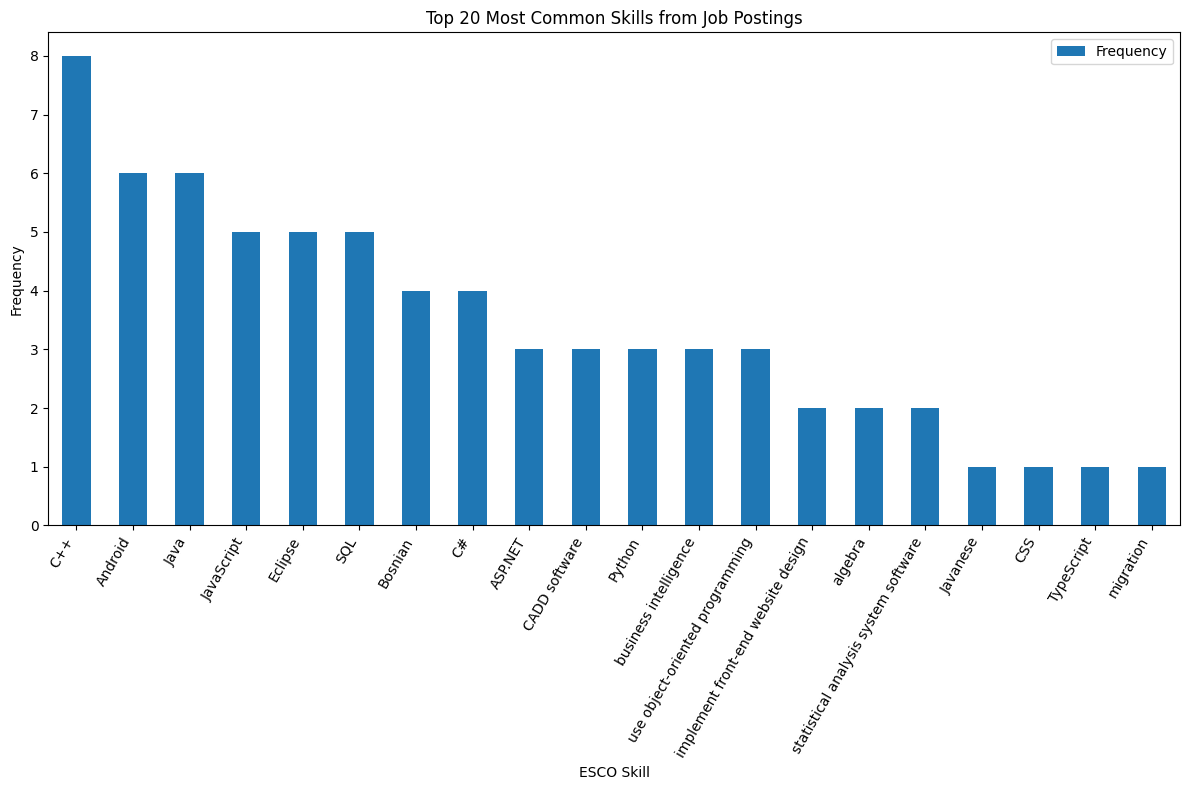

In [235]:
# Initialize a dictionary to store frequencies of ESCO skills
frequency_dict = {}
threshold = 0.85
# Iterate through the similarity results
for r in res:
    esco_skill = r[1]
    similarity = r[2]
    # Check if similarity is above the threshold 0.8
    if similarity > threshold:  # Adjust threshold as needed
        # If the ESCO skill is already in the frequency dictionary, increment its count
        if esco_skill in frequency_dict:
            frequency_dict[esco_skill] += 1
        # Otherwise, add it to the dictionary with count 1
        else:
            frequency_dict[esco_skill] = 1

# Convert the frequency dictionary to a DataFrame
frequency_df = pd.DataFrame.from_dict(frequency_dict, orient='index', columns=['Frequency'])

# Sort the DataFrame by frequency in descending order and select the top 10
top_20_skills = frequency_df.sort_values(by='Frequency', ascending=False).head(20)

# Plot the bar chart
top_20_skills.plot(kind='bar', figsize=(12, 8))
plt.xlabel('ESCO Skill')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Skills from Job Postings')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


# Using TF-IDF to find top 20 most important sentences

In [237]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identify_top_sentences(sentences, top_n=20):
    # Join all sentences into a single document
    document = ' '.join(sentences)

    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Fit the vectorizer on the single document to create the TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform([document])

    # Get the sentence frequencies from the TF-IDF matrix
    sentence_freq = tfidf_matrix.toarray()[0]

    # Sort the sentence frequencies in descending order
    sorted_sentence_freq = sorted(enumerate(sentence_freq), key=lambda x: x[1], reverse=True)

    # Select the top N sentences
    top_sentences = [(sentences[idx], freq) for idx, freq in sorted_sentence_freq[:top_n]]

    return top_sentences

# Call the function with your list of sentences
top_20_sentences = identify_top_sentences(sentences)

# Print the top 20 most frequently occurring sentences
for sentence, frequency in top_20_sentences:
    print(f"{sentence}: {frequency}")

Android: 0.6882728709923808
Communicate technical problems, processes and solutions: 0.40877119749293683
Criminal record check: 0.22010756788081212
API: 0.15721969134343725
Work under pressure: 0.14324460766846503
Networking software: 0.14324460766846503
Design: 0.12577575307474978
Excellent oral communication: 0.10131935664354844
Java: 0.09782558572480539
MAC: 0.09782558572480539
Programming software: 0.09782558572480539
Computer-aided design (CAD): 0.08734427296857625
Mapping and data visualization software: 0.08385050204983319
Fast-paced environment: 0.08385050204983319
Plan, design and co-ordinate the development, installation, integration and operation of computer-based systems: 0.08385050204983319
Develop data, process and network models to optimize architecture and to evaluate the performance and reliability of designs: 0.07686296021234709
Android: 0.07686296021234709
Analytical: 0.07686296021234709
iOS: 0.07686296021234709
C: 0.07336918929360405
